https://colab.research.google.com/drive/1xyaAMav_gTo_KvpHrO05zWFhmUaILfEd?usp=sharing

# <strong> A - Importation de modules importants </strong>

In [1]:
# Transformers installation
#! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [2]:
import pandas as pd
import numpy as np

######################################################################################
import import_ipynb
from Brice_KENGNI_ZANGUIM_2_1_script_functions_17_08_2022 import get_train_test_index, print_scores, plot_confusion_matrix, World_cloud_show

importing Jupyter notebook from Brice_KENGNI_ZANGUIM_2_1_script_functions_17_08_2022.ipynb


# <strong> B - Chargement des données </strong>

In [3]:
data = {}
for data_name in ["train_data","test_data","validation_data"] : 
    data[data_name] = pd.read_csv(f"{data_name}_lemma.csv")
    data[data_name] = data[data_name].loc[ get_train_test_index(data[data_name],"labels",(1000,2,2) )[0] ,: ]
    data[data_name].dropna( inplace = True )

In [4]:
sentences= {}
labels = {}

for data_name in ["train_data","test_data","validation_data"] : 
    sentences[data_name] = data[data_name].text
    labels[data_name] = data[data_name].labels

# <strong> C - Initialisation du tokenizer et du modèle </strong>

In [5]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import logging as hf_logging

hf_logging.set_verbosity_error()

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

# <strong> C - Encodage du text </strong>

In [7]:
input_ids = {}
attention_masks = {}    


for data_name in ["train_data","test_data","validation_data"] :     
    input_ids[data_name] = []
    attention_masks[data_name] = []

    for sent in sentences[data_name]:
        bert_inp = bert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = 32, pad_to_max_length = True, return_attention_mask = True)
        input_ids[data_name].append(bert_inp['input_ids'])
        attention_masks[data_name].append(bert_inp['attention_mask'])

    input_ids[data_name] = np.asarray(input_ids[data_name])
    attention_masks[data_name] = np.array(attention_masks[data_name])
    labels[data_name] = np.array(labels[data_name])


# <strong> C - Sauvegarde des données  </strong>

import pickle

load_file = True

if load_file :
    pickle_inp_path='bert_inp.pkl'
    pickle_mask_path='bert_mask.pkl'
    pickle_label_path='bert_label.pkl'

    pickle.dump((input_ids),open(pickle_inp_path,'wb'))
    pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
    pickle.dump((labels),open(pickle_label_path,'wb'))
else :
    input_ids=pickle.load(open(pickle_inp_path, 'rb'))
    attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
    labels=pickle.load(open(pickle_label_path, 'rb'))

# <strong> C - Definition du modèle  </strong>

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

In [10]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',
                                                mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True )
metric = tf.keras.metrics.SparseCategoricalAccuracy( 'accuracy' )
optimizer = tf.keras.optimizers.Adam( learning_rate = 2e-5 , epsilon = 1e-08 )

bert_model.compile( loss = loss , optimizer = optimizer , metrics = [ metric ] )

print( '\nBert Model',bert_model.summary() )


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


# <strong> C - Entrainement du modèle  </strong>

In [11]:
history=bert_model.fit([ input_ids["train_data"] , attention_masks["train_data"] ], labels["train_data"],
                    batch_size=32,epochs=5, 
                    validation_data=( [ input_ids["validation_data"] , attention_masks["validation_data"] ], labels["validation_data"] ),
                    use_multiprocessing=True,callbacks=callbacks )

Epoch 1/5
63/63 [==============================] - 204s 3s/step - loss: 0.6777 - accuracy: 0.5570 - val_loss: 0.5995 - val_accuracy: 0.6915
Epoch 2/5
63/63 [==============================] - 151s 2s/step - loss: 0.5376 - accuracy: 0.7505 - val_loss: 0.5589 - val_accuracy: 0.7125
Epoch 3/5
63/63 [==============================] - 143s 2s/step - loss: 0.4029 - accuracy: 0.8245 - val_loss: 0.6013 - val_accuracy: 0.7030
Epoch 4/5
63/63 [==============================] - 125s 2s/step - loss: 0.2707 - accuracy: 0.8970 - val_loss: 0.7559 - val_accuracy: 0.7040
Epoch 5/5
63/63 [==============================] - 119s 2s/step - loss: 0.1952 - accuracy: 0.9345 - val_loss: 0.7970 - val_accuracy: 0.7030


# <strong> C - Sauvegarde du modèle  </strong>

In [12]:
save_model = False

In [13]:
if save_model :
    bert_model.save("bert_model")

# <strong> D - Prédiction sur les données de test  </strong>

In [14]:
preds = bert_model.predict([input_ids["test_data"],attention_masks["test_data"]  ],batch_size=32, use_multiprocessing=True)

63/63 [==============================] - 53s 715ms/step


In [15]:
pred_labels = preds["logits"].argmax(axis=1)
pred_labels

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

# <strong> E - Métriques d'évaluation  </strong>

In [16]:
from sklearn.metrics import classification_report

In [17]:
print(classification_report(labels["test_data"],pred_labels))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1000
           1       0.75      0.61      0.67      1000

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.70      0.70      2000



# <strong> F - Evaluations du modèle  </strong>

In [18]:
bert_model.evaluate([input_ids["train_data"] , attention_masks["train_data"]  ], labels["train_data"],batch_size=32,
                    use_multiprocessing=True)


63/63 [==============================] - 54s 850ms/step - loss: 0.0926 - accuracy: 0.9745


[0.0925612822175026, 0.9745000004768372]

In [19]:
bert_model.evaluate([input_ids["test_data"] , attention_masks["test_data"]  ], labels["test_data"],batch_size=32,
                    use_multiprocessing=True)


63/63 [==============================] - 45s 701ms/step - loss: 0.7988 - accuracy: 0.7045


[0.7988057136535645, 0.7045000195503235]

In [20]:
bert_model.evaluate([input_ids["validation_data"] , attention_masks["validation_data"]  ], labels["validation_data"],batch_size=32,
                    use_multiprocessing=True)


63/63 [==============================] - 12s 189ms/step - loss: 0.7970 - accuracy: 0.7030


[0.796978771686554, 0.703000009059906]

# <strong> G - Matrice de confusion  </strong>

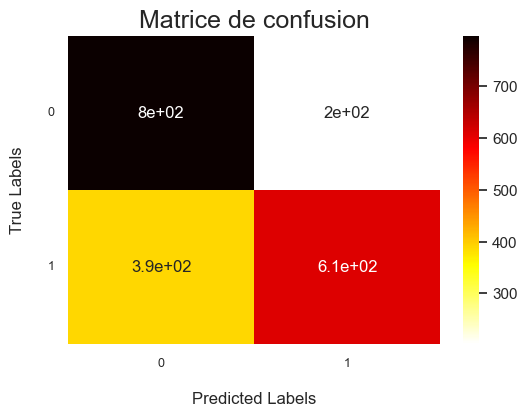

In [21]:
plot_confusion_matrix(labels["test_data"],pred_labels, figsize=(6,4))